# Machine Learning with PySpark on an EMR Cluster

Today, we'll explore how you can use your PySpark coding skills to train a machine learning model on an AWS EMR Cluster. Specifically, we'll be working with all of the customer reviews for books in [Amazon's large customer reviews dataset on S3](https://s3.amazonaws.com/amazon-reviews-pds/readme.html). Note that this notebook is meant to be run on an EMR cluster, using a PySpark kernel.

First (after configuring our PySpark environment), let's load the customer book reviews data from S3 into our Spark session and install a few relevant libraries. The books data is spread across multiple parquet files (as we can see via the AWS CLI below), so we use the wildcard (\*) to indicate that we want the data from all of these files to be included within our dataframe, spread out over our EMR cluster in partitions.

In [ ]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [ ]:
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

In [3]:
data = spark.read.parquet('s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now that we have our data loaded in a DataFrame, let's take a look at its structure and contents. We can see that there is a lot of data here (20 million rows, which amounts to around 10 GB worth of data!), even in this small subset of the overall (~50 GB) Amazon Customer Reviews dataset.

In [4]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 15
Total Rows: 20726160
root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)

And we can also see that each row in the dataset is an individual book, followed by data about that book:

In [5]:
data[['product_title', 'total_votes', 'star_rating']].show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+-----------+
|       product_title|total_votes|star_rating|
+--------------------+-----------+-----------+
|Standing Qigong f...|         10|          5|
|A Universe from N...|          7|          4|
|Hyacinth Girls: A...|          0|          4|
|        Bared to You|          1|          5|
|     Healer: A Novel|          0|          5|
|The Missionary Po...|          7|          4|
|I'm Tired of Bein...|          1|          4|
|Fifty Shades of G...|          7|          1|
|The Thrill of Vic...|          0|          4|
|Fifty Shades of G...|          9|          5|
|Romeo and Juliet ...|          0|          4|
|Wheat Belly: Lose...|          1|          5|
|Dangerous Dessert...|          0|          5|
|Consciousness Bey...|          0|          5|
|The Catcher in th...|          6|          1|
|Fearless: The Und...|          0|          4|
|Best-Ever Big Sister|          0|          5|
|      The Book Thief|          1|          5|
|  Large Prin

Now, let's say that over the course of our exploratory data analysis, we found a pattern such as the following -- demonstrating that the number of votes associated with a book seems to be negatively correlated with its star rating:

In [6]:
stars_votes = data.groupBy('star_rating') \
                  .avg('total_votes') \
                  .sort('star_rating', ascending=False)

stars_votes.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|star_rating|  avg(total_votes)|
+-----------+------------------+
|          5| 4.011696418369872|
|          4| 3.934886568298001|
|          3|  6.55434303072471|
|          2| 10.45506325221873|
|          1|20.341088010415092|
+-----------+------------------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

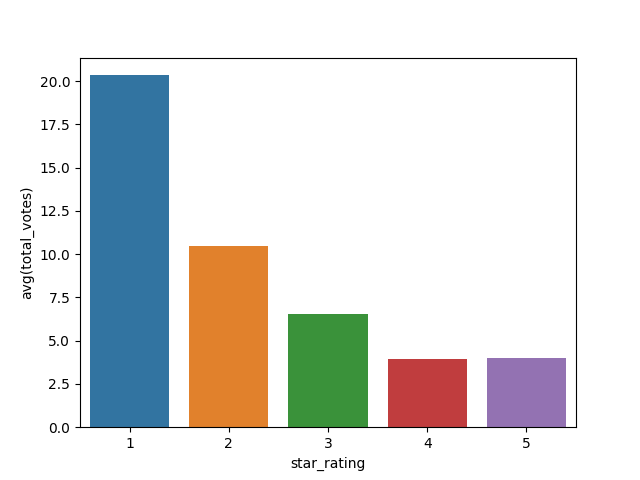

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

df = stars_votes.toPandas()

# Close previous plots; otherwise, will just overwrite and display again
plt.close()

sns.barplot(x='star_rating', y='avg(total_votes)', data=df)
%matplot plt

"Good" reviews (i.e. those with a 4 or 5 star rating) seem to have a lot fewer votes than products with other star ratings. The next step in our analysis might be to attempt to formally model this relationship to assess exactly how predictive the total of number of votes associated with a book are of a "good" review vs. a "bad" review.

Let's implement such a simple model using [Spark's MLlib library](https://spark.apache.org/docs/latest/ml-guide.html), which implements a wide variety of standard ML models and statistical tests in Spark. First, let's create a column that indicates whether a review is good or bad. We'll use this column as labels for machine learning. Note that we're working with a sampled subset of the data so that we can efficiently process the data during the class session (but we could otherwise split the entire dataset into training and test datasets).

In [8]:
# Good == 1, Bad == 0 (cast as integers so that pyspark.ml can understand them)
# Persist in memory to speed up I/O during training
sampled_data = data.sample(fraction=0.0001, seed=0) \
                   .withColumn('good_review', 
                               (data.star_rating >= 4).cast("integer")) \
                   .persist()

# Check to make sure new column is capturing star_rating correctly
sampled_data[['star_rating', 'good_review']].show(5)

# Take a look at how many good and bad reviews we have, respectively
# Note that our data is very unbalanced -- ignoring for now, though
(sampled_data.groupBy('good_review')
     .count()
     .show()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+
|star_rating|good_review|
+-----------+-----------+
|          5|          1|
|          5|          1|
|          4|          1|
|          4|          1|
|          5|          1|
+-----------+-----------+
only showing top 5 rows

+-----------+-----+
|good_review|count|
+-----------+-----+
|          1| 1657|
|          0|  356|
+-----------+-----+

Then, let's use the `VectorAssembler` to get our total_votes feature into a form that `pyspark.ml` expects it to be in (as per the DataCamp tutorial).

In [9]:
from pyspark.ml.feature import VectorAssembler

features = ['total_votes']
assembler = VectorAssembler(inputCols = features, outputCol = 'features')

sampled_data = assembler.transform(sampled_data)
sampled_data[['good_review', 'total_votes', 'features']].show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+--------+
|good_review|total_votes|features|
+-----------+-----------+--------+
|          1|          0|   [0.0]|
|          1|          1|   [1.0]|
|          1|          3|   [3.0]|
|          1|          0|   [0.0]|
|          1|          0|   [0.0]|
|          1|          1|   [1.0]|
|          1|          0|   [0.0]|
|          1|          1|   [1.0]|
|          1|          0|   [0.0]|
|          1|          1|   [1.0]|
|          1|          2|   [2.0]|
|          1|          0|   [0.0]|
|          1|          1|   [1.0]|
|          1|          0|   [0.0]|
|          1|          1|   [1.0]|
|          1|         10|  [10.0]|
|          1|          2|   [2.0]|
|          1|          0|   [0.0]|
|          1|          1|   [1.0]|
|          0|          7|   [7.0]|
+-----------+-----------+--------+
only showing top 20 rows

Then, we can split up our data into training and test data and train a logistic regression model on our training data.

In [10]:
from pyspark.ml.classification import LogisticRegression

train, test = sampled_data.randomSplit([0.7, 0.3], seed=7)

lr = LogisticRegression(featuresCol='features', labelCol='good_review')
model = lr.fit(train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And, finally, we can make predictions for our test data and see how good our model is. Note that our predictive accuracy is not bad overall. However, from our "false positive rate by label" metric, we can see that our model is essentially just predicting that most reviews will be "good" reviews (label 1) -- likely because of our highly unbalanced data (and perhaps use of only a small sample of the data). Accordingly, you'll notice that our AUC is OK, but not stellar (see ROC Curve below).

In [11]:
# Training Summary Data
trainingSummary = model.summary
evaluationSummary = model.evaluate(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
print("Training AUC: " + str(trainingSummary.areaUnderROC))
print("Test AUC: ", str(evaluationSummary.areaUnderROC))

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
    
print("\nTraining Accuracy: " + str(trainingSummary.accuracy))
print("Test Accuracy: ", str(evaluationSummary.accuracy))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.6931806051507022
Test AUC:  0.712657142857143

False positive rate by label (Training):
label 0: 0.001728608470181504
label 1: 0.9960159362549801

True positive rate by label (Training):
label 0: 0.00398406374501992
label 1: 0.9982713915298185

Training Accuracy: 0.8210227272727273
Test Accuracy:  0.8264462809917356

In [13]:
# Get ROC curve and send it to Pandas so that we can plot it
roc_df = evaluationSummary.roc.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

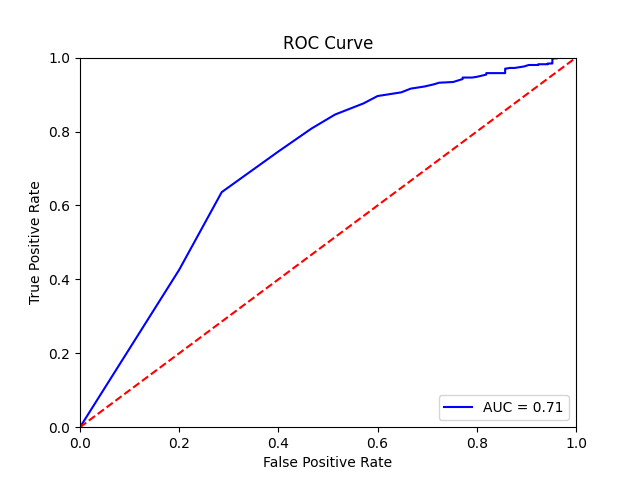

In [14]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', 
         label = 'AUC = %0.2f' % evaluationSummary.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt

Note that if we wanted to try several different combinations of hyperparameters for our model (i.e. "tune" the model), MLlib has built-in classes for [searching a hyperparameter grid via cross validation](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation) (in parallel on our cluster), which you also saw in the DataCamp tutorial assigned for today.